In [1]:
import urllib.request, json 
from datetime import date
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import httplib2
import csv

In [2]:
link = "https://api.github.com/search/issues?q=is:pr+repo:jabref/jabref"

In [3]:
class User:
    def __init__(self,login,twitter,gists,repos,followers,following):
        self.login = login
        self.twitter = twitter
        self.gists = gists
        self.repos = repos
        self.followers = followers
        self.following = following
    def getLogin(self):
        return self.login
    def getTwitter(self):
        return self.twitter
    def getGists(self):
        return self.gists
    def getRepos(self):
        return self.repos
    def getFollowers(self):
        return self.followers
    def getFollowing(self):
        return self.following
class Pull:
    def __init__(self,url,title, body, score,number, state, created_at,commits,additions,deletions,change_files,user):
        self.url = url
        self.title = title
        self.body = body
        self.score = score
        self.number = number
        self.state = state
        self.created_at = created_at
        self.commits = commits
        self.additions = additions
        self.deletions = deletions
        self.change_files = change_files
        self.user = user
    def getUser(self):
        return self.user
    def getPullURL(self):
        return self.url
    def getTitle(self):
        return self.title
    def getBody(self):
        return self.body
    def getScore(self):
        return self.score
    def getNumber(self):
        return self.number
    def getState(self):
        return self.state
    def getCreatedat(self):
        return self.created_at
    def getCommits(self):
        return self.commits
    def getDeletions(self):
        return self.deletions
    def getAdditions(self):
        return self.additions
    def getChangefiles(self):
        return self.change_files
    def toString(self):
        return "Title: "+self.getTitle()+", Score: "+str(self.getScore())+", Number: "+str(self.getNumber())+", Createdat: "+str(self.getCreatedat())
class Project:
    def __init__(self, name,login,description,homepage,license,forks, watchers,date_of_collection):
        self.name = name
        self.login = login
        self.description = description
        self.homepage = homepage
        self.license = license
        self.forks = forks
        self.watchers = watchers
        self.date_of_collection = date_of_collection
        self.pulls = []
    def addPull(self,request):
        self.pulls.append(request)
    def getPullRequests(self):
        return self.pulls
    def getName(self):
        return self.name
    def getLogin(self):
        return self.login
    def getDescription(self):
        return self.description
    def getHomepage(self):
        return self.homepage
    def getLicense(self):
        return self.license
    def getForks(self):
        return self.forks
    def getWatchers(self):
        return self.watchers
    def getDateofcollection(self):
        return self.date_of_collection
    def toString(self):
        return "Name: "+self.getName()+", Login: "+self.getLogin()+", Desc: "+self.getDescription()+"\n Homepage:"+self.getHomepage()+"\nForks: "+self.getForks()+", Watchers: "+self.getWatchers()
class License:
    def __init__(self,key,name,lid,url,node):
        self.key = key
        self.name = name
        self.lid = lid
        self.url = url
        self.node = node
    def getKey(self):
        return self.key
    def getName(self):
        return self.name
    def getLid(self):
        return self.lid
    def getUrl(self):
        return self.url
    def getNode(self):
        return self.node
    def toString(self):
        return "Key: "+self.getKey()+", Name: "+self.getName()+", Lid:"+self.getLid()

In [4]:

def getProjectDetails(link):
    with urllib.request.urlopen(link) as url:
        data = json.loads(url.read().decode())
        name = data["name"]
        owner = data["owner"]
        login = owner["login"]
        forks = data["forks"]
        desc = data["description"]
        lic = data["license"]
        licObj = License(lic["key"],lic["name"],lic["spdx_id"],lic["url"],lic["node_id"])
        homepage = data["homepage"]
        watchers = data["watchers"]
        date_of_collection = date.today()
        projectObj = Project(name,login,desc,homepage,licObj,str(forks),str(watchers),date_of_collection)
        
        return projectObj


In [5]:
def collect(link):
    with urllib.request.urlopen(link) as url:
        data = json.loads(url.read().decode())
        #scrape project basic details
        items = data["items"]
        repository_url = items[0]['repository_url']
        project = getProjectDetails(repository_url)
    
        #scrape pull requests now
        for item in items:
            created_at = item["created_at"]
            body = item["body"]
            score = item["score"]
            pull_url = item["pull_request"]["url"]
            with urllib.request.urlopen(pull_url) as pul:
                pull_request = json.loads(pul.read().decode())
                title = pull_request["title"]
                number = pull_request["number"]
                state = pull_request["state"]
                additions = pull_request["additions"]
                deletions = pull_request["deletions"]
                commits = pull_request["commits"]
                change_files = pull_request["changed_files"]
                user = pull_request["user"]["login"]
                pull = Pull(pull_url,title, body, score,number, state, created_at,commits,additions,deletions,change_files,user)
                project.addPull(pull)
        return project

In [6]:
def display(project):
    print("Project Details Collected On: "+str(project.getDateofcollection()))
    print(project.toString())
    print("Project License: "+project.getLicense().toString())
    
    for pr in project.getPullRequests():
        print(pr.toString())
        
def write(project):
    #writing project.csv
    import csv   
    #fields=['name','login','description','homepage','license','forks', 'watchers','date_of_collection']
    with open('projects.csv', 'a', newline='') as f:
        writer = csv.writer(f)
        writer.writerow([project.getName(),project.getLogin(),project.getDescription(),project.getHomepage(),project.getLicense().getKey(),
                    project.getForks(),project.getWatchers(),project.getDateofcollection()])

    pullFields = ['url','title','body','score','number','state','created_at','commits','additions','deletions','change_files','user']
    #writing pull requests
    with open('projects/project_'+project.getLogin()+'.csv', 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(pullFields)
        for pr in project.getPullRequests():
            writer.writerow([pr.getPullURL(),pr.getTitle(),pr.getBody(),pr.getScore(),pr.getNumber(),pr.getState(),pr.getCreatedat(),
                        pr.getCommits(),pr.getAdditions(),pr.getDeletions(),pr.getChangefiles(),pr.getUser()])


In [7]:

def twitter(project):
    users = []
    logins = []
    # check twitter accounts
    for pr in project.getPullRequests():
        login = pr.getUser()
        found = False
        for s in logins:
            if s == login:
                found = True
        if found ==  False:
            http = httplib2.Http()
            resp = http.request('https://twitter.com/'+login)[0]
            twitter = False
            if resp.status == 200:
                twitter = True
            link = 'https://api.github.com/users/'+login
            with urllib.request.urlopen(link) as url:
                data = json.loads(url.read().decode())
                repos = data["public_repos"]
                gist = data["public_gists"]
                followers = data["followers"]
                following = data["following"]
                u = User(login,twitter,repos,gist,followers,following)
                users.append(u)
        logins.append(login)
    return users

In [8]:
def writeUsers(users):
    #userFields = ['login','twitter','repos','gist','followers','following']
    #writing users
    with open('users.csv', 'a', newline='') as f:
        writer = csv.writer(f)
        #writer.writerow(userFields)
        for user in users:
            writer.writerow([user.getLogin(),user.getTwitter(),user.getRepos(),user.getGists(),user.getFollowers(),user.getFollowing()])


In [9]:
def visuailizeResults(project):
    state = []
    commits = []
    additions = []
    deletions = []
    createdat = []
    userlist = []
    change_files = []
    for pr in project.getPullRequests():
        state.append(pr.getState())
        commits.append(pr.getCommits())
        additions.append(pr.getAdditions())
        deletions.append(pr.getDeletions())
        createdat.append(pr.getCreatedat())
        change_files.append(pr.getChangefiles())
        userlist.append(pr.getUser())
    df = pd.DataFrame(list(zip(state, commits,additions,deletions,createdat,change_files,userlist)), columns =['state', 'commits','additions','deletions','createdat','change_files','user'])
    df['year'] = pd.DatetimeIndex(df['createdat']).year
    df['month'] = pd.DatetimeIndex(df['createdat']).month
    df['day'] = pd.DatetimeIndex(df['createdat']).day
    df['date'] = pd.to_datetime(df.createdat, format='%Y-%m-%d')
    df.head()
    df.boxplot(by ='state', column =['commits'], grid = True) 
    df.boxplot(by ='state', column =['additions','deletions'], grid = True)
    df.boxplot(by ='user', column =['change_files'], grid = True)
    
    colors = (0,0,0)
    area = np.pi*3
    plt.scatter(additions, deletions, s=area, c=colors, alpha=0.5)
    plt.title('Additions vs Deletions')
    plt.xlabel('Additions')
    plt.ylabel('Deletions')
    plt.show()
    df.hist(column='commits')
    plt.plot(df['date'].dt.day,df['commits'])
    plt.title('Commits/Day')
    plt.xlabel('Date')
    plt.ylabel('Commits')
    plt.show()
    
    df_open = df[df.state == "open"]
    df_close = df[df.state == "closed"]

    open_res = df_open['date'].dt.day.value_counts().sort_index()
    close_res = df_close['date'].dt.day.value_counts().sort_index()

    plt.plot(open_res,label="Open")
    plt.plot(close_res,label="Closed")
    plt.title('(Open vs Close)Commits/Day')
    plt.xlabel('Date')
    plt.ylabel('Commits')
    plt.legend(loc="upper left")
    plt.show()

    plt.plot(df['date'].dt.day,df['commits'])
    plt.title('Commits/Day')
    plt.xlabel('Date')
    plt.ylabel('Commits')
    plt.show()
def corr():
    #coorelation
    df = pd.read_csv("users.csv") 
    df.corr(method ='pearson') 
    df = pd.read_csv("projects.csv") 
    df.corr(method ='pearson') 

In [10]:
import unittest


class Testing(unittest.TestCase):
    def test_User(self):
        user = User('tobiasdiez','TRUE',1,35,13,0)
        login = 'tobiasdiez'
        self.assertEqual(login, user.getLogin())

    def test_Project1(self):
        pr = Project('jabref','JabRef','Graphical Java application for managing BibTeX and biblatex (.bib) databases','https://www.jabref.org',None,'1043','1488','12/2/2019')
        a = 'Name: jabref, Login: JabRef, Desc: Graphical Java application for managing BibTeX and biblatex (.bib) databases\n Homepage:https://www.jabref.org\nForks: 1043, Watchers: 1488'
        b = pr.toString()
        self.assertEqual(a, b)
    
    def test_Project2(self):
        pr = Project('jabref','JabRef','Graphical Java application for managing BibTeX and biblatex (.bib) databases','https://www.jabref.org',None,'1043','1488','12/2/2019')
        a = 'jabref'        
        b = pr.getName()
        self.assertEqual(a, b)
        
    def test_Twitter(self):
        user = User('tobiasdiez','TRUE',1,35,13,0)
        flag = 'TRUE'
        self.assertEqual(flag, user.getTwitter())
        
    def test_ProjectsLic(self):
        pr = Project('jabref','JabRef','Graphical Java application for managing BibTeX and biblatex (.bib) databases','https://www.jabref.org',None,'1043','1488','12/2/2019')
        a = None
        b = pr.getLicense()
        self.assertEqual(a, b)
        
    

if __name__ == '__main__':
    unittest.main(argv=['first-arg-is-ignored'], exit=False)

.....
----------------------------------------------------------------------
Ran 5 tests in 0.000s

OK


Writing collected details in csv files
Project Details Collected On: 2019-12-05
Name: jabref, Login: JabRef, Desc: Graphical Java application for managing BibTeX and biblatex (.bib) databases
 Homepage:https://www.jabref.org
Forks: 1042, Watchers: 1488
Project License: Key: mit, Name: MIT License, Lid:MIT
Title: incrementa validacoes para o campo year, Score: 1.0, Number: 5710, Createdat: 2019-12-04T15:43:37Z
Title: New Crowdin translations, Score: 1.0, Number: 5709, Createdat: 2019-12-04T10:24:04Z
Title: Revert "Fix #5615 side pane not remembering position (#5629)", Score: 1.0, Number: 5706, Createdat: 2019-12-03T13:04:59Z
Title: Last Minute Changes 5.0-beta, Score: 1.0, Number: 5705, Createdat: 2019-12-03T11:20:24Z
Title: [WIP] Offer preview based on .bst file, Score: 1.0, Number: 5702, Createdat: 2019-12-02T23:00:24Z
Title: Bump classgraph from 4.8.54 to 4.8.58, Score: 1.0, Number: 5697, Createdat: 2019-12-02T07:16:15Z
Title: Bump unirest-java from 3.1.04 to 3.2.00, Score: 1.0, Numb

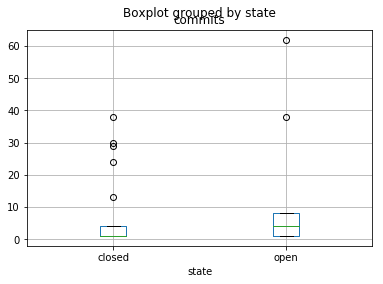

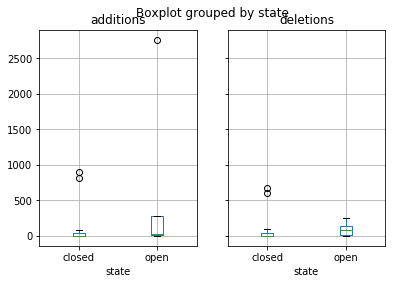

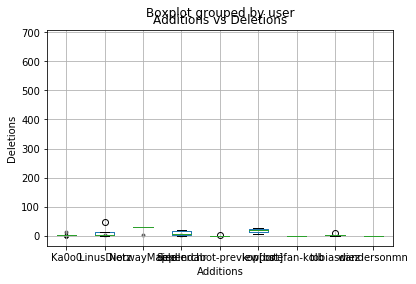

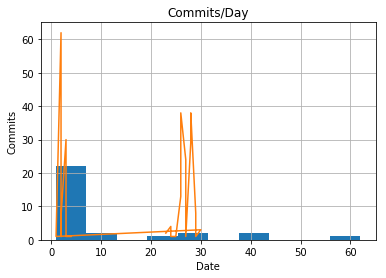

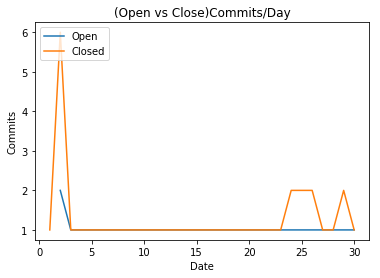

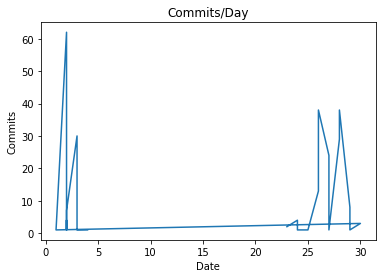

completed


In [11]:
#userinput = input("Please Enter URL:")
owner = input("Enter Owner: ")
rep = input("Enter Rep Name: ")
userinput = "https://api.github.com/search/issues?q=is:pr+repo:"+owner+"/"+rep
#userinput = link
project = collect(userinput)
print("Writing collected details in csv files")
display(project)
write(project)
users = twitter(project)
writeUsers(users)
visuailizeResults(project)
corr()
print("completed")